In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import h5py as h5
import numpy as np
import os

from glob import glob
from tqdm import tqdm

from scipy.interpolate import interp1d
from scipy.optimize import ridder

import matplotlib.pyplot as plt
plt.style.use("../paper.mplstyle")

import sys
sys.path.append("../")
sys.path.append("../../ASTERIA/python/")
from ic_sn_hnl import parameterized_flux_from_files, units
from ic_sn_hnl.flux.parametrize_flux import compute_moment, Params, parameterized_flux_from_h5, deserialize
from ic_sn_hnl.flux.sanitize_flux import sanitize_flux

from tqdm import tqdm

import os
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"

In [17]:
infiles = glob("../data/majoron/from_yingying/*.csv")
for infile in tqdm(infiles):
    outfile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    a = np.genfromtxt(infile, delimiter=",")
    a[:, 2] = a[:, 2] / 6
    np.save(outfile, a)

100%|██████████| 35/35 [17:12<00:00, 29.50s/it]


In [18]:
infile = "./dphi-dEdt-100MeV-gn11dot8-100s-nf.csv"
outfile = "./data/majoran_fluxes.h5"

if not os.path.exists(outfile):
    with h5.File(outfile, "w") as _:
        pass

for infile in infiles:
    key = infile.split("/")[-1].replace(".csv", "")
    infile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    arr = np.load(infile)
    times = np.sort(np.unique(arr[:, 0])) * units["second"]
    energies = np.sort(np.unique(arr[:, 1])) * units["MeV"]
    fluxes = np.empty(times.shape + energies.shape + (3,),)

    for idx in range(len(times)):
        flux = arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
        flux = np.where(flux >= 0, flux, 0) # Sometimes numerical issues can sneak in to give negative fluxes
        fluxes[idx, :, 0] = flux # nue
        fluxes[idx, :, 1] = flux # nuebar
        fluxes[idx, :, 2] = flux # nux per flavor

    with h5.File(outfile, "r+") as h5f:

        if key in h5f.keys():
            del h5f[key]

        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)

In [5]:
# key = "sm_flux"
# nue_arr = np.genfromtxt("./fluxactivenuE.csv", delimiter=",")
# nuebar_arr = np.genfromtxt("./fluxactivenuEBar.csv", delimiter=",")
# nux_arr = np.genfromtxt("./fluxactivenuX.csv", delimiter=",")

# times = np.sort(np.unique(nue_arr[:, 0]))
# energies = np.sort(np.unique(nue_arr[:, 1]))

# if not np.all(times==np.sort(np.unique(nuebar_arr[:, 0]))):
#     raise ValueError()
# if not np.all(times==np.sort(np.unique(nux_arr[:, 0]))):
#     raise ValueError()
# if not np.all(energies==np.sort(np.unique(nuebar_arr[:, 1]))):
#     raise ValueError()
# if not np.all(energies==np.sort(np.unique(nux_arr[:, 1]))):
#     raise ValueError()
    
# fluxes = np.empty(times.shape + energies.shape + (3,),)

# for idx in range(len(times)):
#     nue_flux = nue_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
#     nuebar_flux = nuebar_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
#     nux_flux = nux_arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"] / 4
#     # Sometimes numerical issues can sneak in to give negative fluxes
#     nue_flux = np.where(nue_flux >= 0, nue_flux, 0)
#     nuebar_flux = np.where(nuebar_flux >= 0, nuebar_flux, 0)
#     nux_flux = np.where(nux_flux >= 0, nux_flux, 0)
#     fluxes[idx, :, 0] = nue_flux # nue
#     fluxes[idx, :, 1] = nuebar_flux # nuebar
#     fluxes[idx, :, 2] = nux_flux # nux per flavor
    
    
# if not os.path.exists("./data/sm_flux.h5"):
#     with h5.File("./data/sm_flux.h5", "w") as _:
#         pass
    
# with h5.File("./data/sm_flux.h5", "r+") as h5f:

#         if key in h5f.keys():
#             del h5f[key]

#         h5f.create_group(key)
#         h5f[key].create_dataset("energies", data=energies)
#         h5f[key].create_dataset("times", data=times)
#         h5f[key].create_dataset("fluxes", data=fluxes)

In [19]:
key = "sm_flux"
infile = "data/sm_flux.h5"
serialize_file = "./data/serialized_sm_flux.h5"

thin = 1

done_keys = []
if os.path.exists(serialize_file):
    with h5.File(serialize_file) as h5f:
        done_keys = list(h5f.keys())

with h5.File(infile, "r") as h5f:
    for key, group in h5f.items():
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin)
        pflux.serialize(serialize_file, key)

In [ ]:
infile = "data/majoran_fluxes.h5"
serialize_file = "./data/serialized_majoran_fluxes.h5"

thin = 10

done_keys = []
if os.path.exists(serialize_file):
    with h5.File(serialize_file) as h5f:
        done_keys = list(h5f.keys())

with h5.File(infile, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin, track=False)
        pflux.serialize(serialize_file, key)

 40%|████      | 14/35 [3:42:33<8:07:17, 1392.28s/it]

In [ ]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
DTS = np.linspace(0.001, 5, 401) * units["second"]
def find_significance_matrix(sig_hits, sm_hits, bg_hits, times, tmins=TMINS, dts=DTS):
    significance = np.full(tmins.shape + dts.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, dt in enumerate(dts):
            m = np.logical_and(tmin < times, times < tmin+dt)
            if not m.sum():
                continue
            significance[idx, jdx] = likelihood(sig_hits[m], sm_hits[m], bg_hits[m])
    return significance, tmins, dts

def likelihood(sig_hits, sm_hits, bg_hits):
    n_obs = (bg_hits + sm_hits).sum()
    n_exp = (sig_hits + bg_hits + sm_hits).sum()
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

In [ ]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="majoran.txt"
)
out = {}

with h5.File("data/serialized_majoran_fluxes.h5", "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="majoran.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="majoran.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

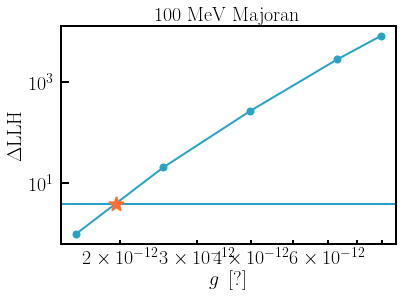

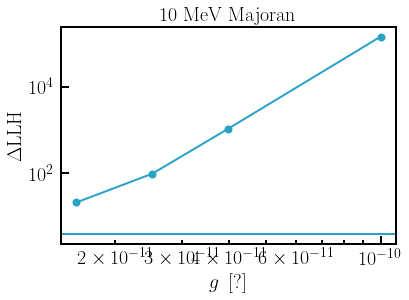

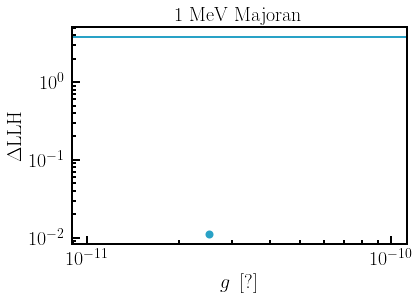

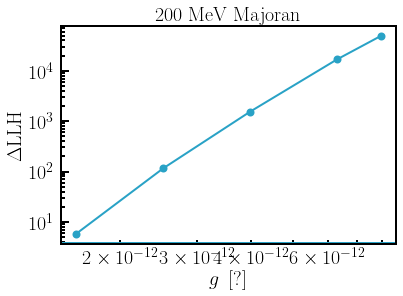

In [16]:
for k, v in out.items():
    # print(k)
    v = sorted(v)
    _, ax = plt.subplots()
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    plot_sens = True
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
    except ValueError:
        plot_sens = False
    
    # print(res)
    
    ax.plot(couplings, significnces)
    ax.scatter(couplings, significnces)
    if plot_sens:
        ax.scatter([np.exp(res)], [np.exp(interp(res))], marker="*", zorder=10, s=200, label="Sensitivity")
    ax.loglog()
    ax.axhline(3.841)
    
    ax.set_title(f"{int(k)} MeV Majoran", fontsize=20)
    ax.set_xlabel(r"$g~\left[?\right]$")
    ax.set_ylabel(r"$\Delta \mathrm{LLH}$")
    
    ax.axhline(3.841, label=r"$\Delta\mathrm{LLH}=3.84$")
    plt.savefig(f"./figures/majoran_sensitivities_{int(k)}MeV.pdf")

    plt.show()
    
    